# **3D CT(폐) 영상 분류**

- copy from https://keras.io/examples/vision/3D_image_classification/

- Key Word : 3D 영상, 분류, CT 영상, keras.utils.get_file(), zipfile, 여러 영상 하나로 그리기

## **1. 라이브러리 불러오기**

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## **2. 데이터 준비**

- 다운로드

In [2]:
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

1045162547/1045162547 [==============================] - 23s 0us/step


'/content/CT-23.zip'

- 폴더 생성

In [3]:
os.makedirs("MosMedData")

- 압축 풀기

In [4]:
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

```
MosMedData/
  CT-0/
    study_0001.nii.gz
    study_0002.nii.gz
    ...
    study_0100.nii.gz
  CT-23/
    study_0939.nii.gz
    study_0940.nii.gz
    ...
    study_1108.nii.gz
```

- 파일 이름 리스팅

In [5]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

print(normal_scan_paths[:3])
print(abnormal_scan_paths[:3])


CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100
['/content/MosMedData/CT-0/study_0059.nii.gz', '/content/MosMedData/CT-0/study_0067.nii.gz', '/content/MosMedData/CT-0/study_0075.nii.gz']
['/content/MosMedData/CT-23/study_1106.nii.gz', '/content/MosMedData/CT-23/study_1073.nii.gz', '/content/MosMedData/CT-23/study_1085.nii.gz']


- 데이터 읽기
  - process_scan()호출해서 읽고 전처리함
  - process_scan()에서 nfile 읽고, resize하고 normalization까지 함

In [6]:
import nibabel as nib

from scipy import ndimage

# 3D CT이미지를 저장하는 nii파일은 nibabel 라이브러리로 읽는다.
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    # 원하는 사이즈 128 x 128 x 64 
    desired_depth = 64
    desired_width = 128
    desired_height = 128

    # 실제 이미지 사이즈
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]

    # 확대 축소 비율
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height

    # 회전
    img = ndimage.rotate(img, 90, reshape=False)

    # 리사이즈 실행
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)

    return img


def process_scan(path):
  
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)

    return volume

In [7]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

- 레이블링 데이터 만들기

In [8]:
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

- train과 val로 데이터 분리

In [9]:
# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


- 데이터 증강
  - 회전 시켜서 데이텨를 증강한다.
  - 그리고 Conv3D를 사용하기 위해 데이터를 (batch, height, width, depth, channel)의 5차원 데이터로 만든다.

In [10]:
import random

from scipy import ndimage

@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

- 데이터 셋 생성

In [11]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

- 이미지 보기

Dimension of the CT scan is: (128, 128, 64, 1)


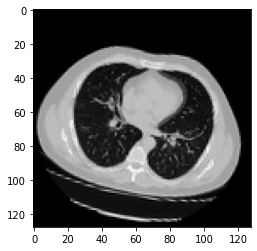

In [12]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
plt.show()

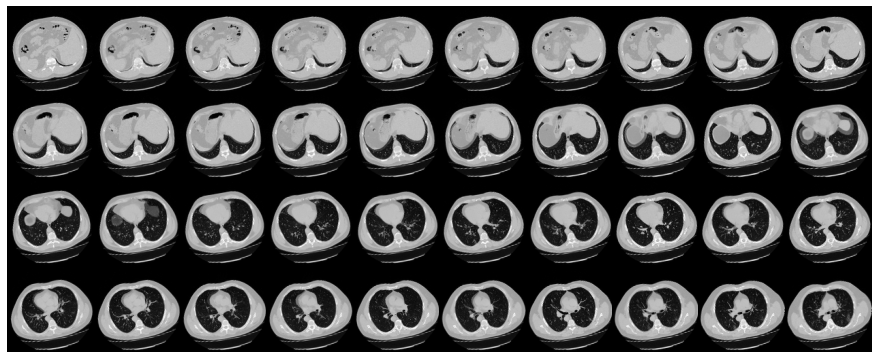

In [13]:

def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

## **3. 모델 생성**

- 모델 구조 정의

In [14]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 126, 126, 62, 64)  1792      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 63, 63, 31, 64)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 31, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 61, 61, 29, 64)    110656    
                                                             

- loss와 optimizer 설정
  - Adam을 사용하면서 학습율을 초기 0.0001로, 100,000회마다 0.96으로 감소시킨다.

In [15]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

- callback 정의
  - 모델 저장과 early stopping

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)

early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

## **4. 모델 학습**

In [17]:
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
70/70 - 34s - loss: 0.7046 - acc: 0.5286 - val_loss: 1.3054 - val_acc: 0.5000 - 34s/epoch - 489ms/step
Epoch 2/100
70/70 - 24s - loss: 0.6625 - acc: 0.6000 - val_loss: 1.9908 - val_acc: 0.5000 - 24s/epoch - 341ms/step
Epoch 3/100
70/70 - 24s - loss: 0.6670 - acc: 0.5857 - val_loss: 1.3818 - val_acc: 0.5000 - 24s/epoch - 342ms/step
Epoch 4/100
70/70 - 24s - loss: 0.6512 - acc: 0.6643 - val_loss: 2.9288 - val_acc: 0.5000 - 24s/epoch - 344ms/step
Epoch 5/100
70/70 - 24s - loss: 0.6672 - acc: 0.5857 - val_loss: 2.4184 - val_acc: 0.5000 - 24s/epoch - 343ms/step
Epoch 6/100
70/70 - 24s - loss: 0.6140 - acc: 0.6643 - val_loss: 2.6313 - val_acc: 0.5000 - 24s/epoch - 343ms/step
Epoch 7/100
70/70 - 25s - loss: 0.6344 - acc: 0.6071 - val_loss: 2.0513 - val_acc: 0.5000 - 25s/epoch - 357ms/step
Epoch 8/100
70/70 - 24s - loss: 0.6347 - acc: 0.7071 - val_loss: 1.0968 - val_acc: 0.5000 - 24s/epoch - 346ms/step
Epoch 9/100
70/70 - 25s - loss: 0.6140 - acc: 0.6286 - val_loss: 0.8698 - val_ac

KeyboardInterrupt: ignored

- 손실 값 그리기

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

## **5. 예측**

In [ ]:
model.load_weights("3d_image_classification.h5")
prediction = model.predict(np.expand_dims(x_val[0], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]

class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )